In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader 
import numpy as np
import matplotlib.pyplot as plt


In [4]:
def creatDownSampling(in_channels,out_channels,f_size=4):
    ds = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=f_size,stride=2,padding=1),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(),
    )
    return ds

def creatUpSampling(in_channels,out_channels,f_size=3,dropout_rate=0):
    us = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels,out_channels,kernel_size=f_size,stride=1,padding=1,),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(),
    )
    if dropout_rate:
        us = nn.Sequential(
            us,
            nn.Dropout(dropout_rate)
        )
    return us


In [5]:
from torch.optim import Adam

class UNET(nn.Module):
    def __init__(self,filters=32):
        super().__init__()
        self.filters = filters
        self.ds1 = creatDownSampling(3,self.filters,4)
        #[-1, 32, 64, 64]
        self.ds2 = creatDownSampling(self.filters,2*self.filters,4)
        #[-1, 64, 31, 31]
        self.ds3 = creatDownSampling(2*self.filters,4*self.filters)
        #[-1, 128, 16, 16] 
        self.ds4 = creatDownSampling(4*self.filters,8*self.filters)
        #[-1, 256, 8, 8]
        self.us1 = creatUpSampling(8*self.filters,4*self.filters)
        #upsample #[-1, 256, 16, 16]
        #conv2d [-1, 128, 16, 16]
        #concat [-1, 256, 32, 32]
        self.us2 = creatUpSampling(8*self.filters,2*self.filters)
        self.us3 = creatUpSampling(4*self.filters,self.filters)
        self.output = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(2*self.filters,3,kernel_size=3,stride=1,padding=1),
            nn.Tanh(),
        )
        self.loss_function = nn.L1Loss()
        self.optimizer = Adam(self.parameters(),lr=0.0005)
    def forward(self,x): #[2,3,256,256]
        d1 = self.ds1(x) #[2, 32, 128, 128]
        d2 = self.ds2(d1)#[2, 64, 64, 64] 
        d3 = self.ds3(d2) #[2, 128, 32, 32]
        d4 = self.ds4(d3)#[2, 256, 16, 16]
        u1 = self.us1(d4) #[2, 128, 32, 32]
        u1 = torch.concatenate([u1,d3],dim=1) #[2, 256, 32, 32]
        u2 = self.us2(u1) #[2, 64, 64, 64]
        u2 = torch.concatenate([u2,d2],dim=1) #[2, 128, 64, 64]
        u3 = self.us3(u2) #[2, 32, 128, 128]
        u3 = torch.concatenate([u3,d1],dim=1) #[2, 64, 128, 128]
        output = self.output(u3) #[2, 3, 256, 256]
        return output
        

    def train(self,x_batch,label_imgs):
        self.optimizer.zero_grad()
        fake_imgs = self.forward(x_batch)

        loss = self.loss_function(fake_imgs,label_imgs)
        loss.backward()
        self.optimizer.step()
        return loss

In [6]:
# [-1,3,128,128] -> [-1,32, 64,64] -> [-1,64,32,32]->[-1,128,16,16]->[-1,256,16,16] ->[-1,1,16,16]

class D(nn.Module):
    def __init__(self,filters=32):
        super().__init__()
        self.filters = filters
        self.d1 = self.conv4(3,filters,norm=False) #[2, 32, 128, 128]
        self.d2 = self.conv4(filters,2*filters) #[2, 64, 64, 64]
        self.d3 = self.conv4(2*filters,4*filters) #[2, 128, 32, 32]
        self.d4 = self.conv4(4*filters,8*filters) #[2, 256, 16, 16]
        self.d5 = nn.Sequential(
                nn.Conv2d(8*filters,1,kernel_size=3,stride=1,padding=1),
            ) #[2, 1, 32, 32]
        # 손실 함수 생성
        self.loss_function = nn.MSELoss()
        # 옵티마이저 생성
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0005)
    def forward(self,x):
        y = self.d1(x)
        y = self.d2(y)
        y = self.d3(y)
        y = self.d4(y)
        y = self.d5(y)
        return y
    def conv4(self,in_channels,out_channels,f_size=4,stride=2,norm=True):
        if norm:
            conv4 = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=f_size,stride=stride,padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2),
            )
        else:
            conv4 = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=f_size,stride=stride,padding=1),
                nn.LeakyReLU(0.2),
            )
        return conv4

    def train(self,x_batch,label):
        self.optimizer.zero_grad()
        y_pred = self.forward(x_batch)
        
        loss = self.loss_function(y_pred,label)
        loss.backward()
        self.optimizer.step()
        return loss


In [7]:
from glob import glob
import cv2 as cv

class apple2orangeDataLoader():
    
    def __init__(self, dataset_name='apple2orange', img_res=(256, 256)):
        self.dataset_name = dataset_name
        self.img_res = img_res
        pass
    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        path_A = glob('./mount/My Drive/Colab Notebooks/GDLgon/data/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./mount/My Drive/Colab Notebooks/GDLgon/data/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = cv.resize(img_A, self.img_res)
                img_B = cv.resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield torch.cuda.FloatTensor(imgs_A.transpose(0,3,1,2)), torch.cuda.FloatTensor(imgs_B.transpose(0,3,1,2))  
            
    def imread(self, path):
        img = cv.imread(path)
        img =cv.cvtColor(img,cv.COLOR_RGB2BGR)
        return img
    

In [ ]:
d_A = D()
d_B = D()
u_A = UNET()
u_B = UNET()
d_A.to(device)
d_B.to(device)
u_A.to(device)
u_B.to(device)
dummy = torch.ones([2,3,256,256])

In [ ]:
%%time
import matplotlib.pyplot as plt


dataloader = apple2orangeDataLoader()
batch_size = 32
patch = int(256/2**4)
disc_patch = (1,patch,patch) #[1,16,16]

real_label = torch.ones((batch_size,)+disc_patch)
fake_label = torch.zeros((batch_size,)+disc_patch)

dA_loss_hist = []
dB_loss_hist = []
gA_loss_hist =[]
gB_loss_hist =[]

num_epochs=50
for epoch in range(num_epochs):
    for iter,(imgs_A,imgs_B) in enumerate(dataloader.load_batch(batch_size=batch_size)):

        fake_B = u_B(imgs_A).detach()
        fake_A = u_A(imgs_B).detach()

        d_B_loss = d_B.train(imgs_B,real_label)
        d_B_fake_loss = d_B.train(fake_B,fake_label)
        d_A_loss =d_A.train(imgs_A,real_label)
        d_A_fake_loss = d_A.train(fake_A,fake_label)

        recons_A = u_A(fake_B)
        recons_B = u_B(fake_A)
        g_A_rec_loss = u_A.train(recons_A,imgs_A)
        g_B_rec_loss = u_B.train(recons_B,imgs_B)
        
        idt_A = u_A(imgs_A)
        idt_B = u_B(imgs_B)
        
        g_A_idt_loss = u_A.train(idt_A,imgs_A)
        g_B_idt_loss = u_B.train(idt_B,imgs_B)

        total_d_A_loss =(d_A_loss.item()+d_A_fake_loss.item())/2
        total_d_B_loss =(d_B_loss.item()+d_B_fake_loss.item())/2
        dA_loss_hist.append(total_d_A_loss)
        dB_loss_hist.append(total_d_B_loss)

        total_g_A_loss =(g_A_rec_loss.item()+g_A_idt_loss.item())/2
        total_g_B_loss =(g_B_rec_loss.item()+g_B_idt_loss.item())/2
        gA_loss_hist.append(total_g_A_loss)
        gB_loss_hist.append(total_g_B_loss)

        
    print(f"Epoch {epoch}: d_A_loss = {total_d_A_loss:.7f} | d_B_loss = {total_d_B_loss:.7f} | total_g_A_loss={total_g_A_loss:.7f} | total_g_B_loss={total_g_B_loss:.7f}")



Epoch 0: d_A_loss = 0.1344838 | d_B_loss = 0.1531797 | total_g_A_loss=0.2831418 | total_g_B_loss=0.3034611
Epoch 1: d_A_loss = 0.0460911 | d_B_loss = 0.0552725 | total_g_A_loss=0.3015414 | total_g_B_loss=0.2890907
Epoch 2: d_A_loss = 0.0319013 | d_B_loss = 0.0203005 | total_g_A_loss=0.2189866 | total_g_B_loss=0.2786466
Epoch 3: d_A_loss = 0.0233177 | d_B_loss = 0.0156662 | total_g_A_loss=0.2639654 | total_g_B_loss=0.2282860
Epoch 4: d_A_loss = 0.0227490 | d_B_loss = 0.0128691 | total_g_A_loss=0.2092816 | total_g_B_loss=0.2519287
Epoch 5: d_A_loss = 0.0253091 | d_B_loss = 0.0069199 | total_g_A_loss=0.2325214 | total_g_B_loss=0.2424786
Epoch 6: d_A_loss = 0.0103203 | d_B_loss = 0.0131895 | total_g_A_loss=0.1978608 | total_g_B_loss=0.2277528
Epoch 7: d_A_loss = 0.0155306 | d_B_loss = 0.0059783 | total_g_A_loss=0.2111820 | total_g_B_loss=0.2421580
Epoch 8: d_A_loss = 0.0165446 | d_B_loss = 0.0072247 | total_g_A_loss=0.2056572 | total_g_B_loss=0.2370666
Epoch 9: d_A_loss = 0.0092962 | d_B_l

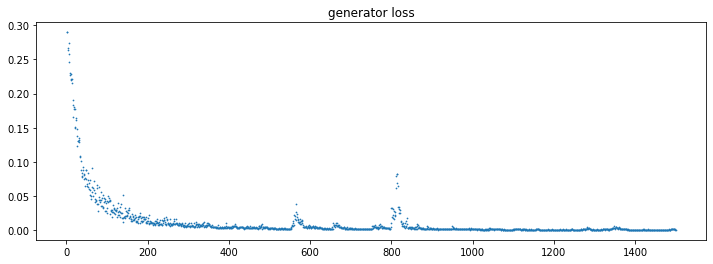

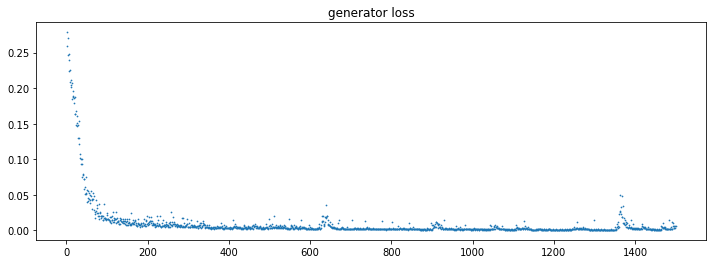

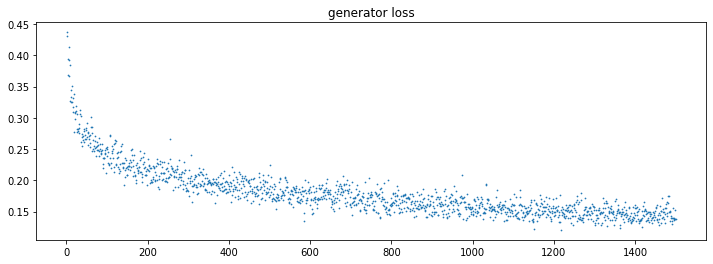

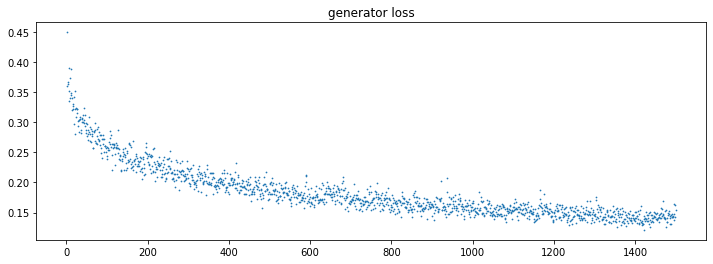

In [ ]:
def visualize(loss_hist):
    plt.figure(figsize=(12,4))
    plt.scatter(np.arange(1,len(loss_hist)+1),loss_hist,s=0.5)
    plt.title('generator loss')
    plt.show()
visualize(dA_loss_hist)
visualize(dB_loss_hist)
visualize(gA_loss_hist)
visualize(gB_loss_hist)

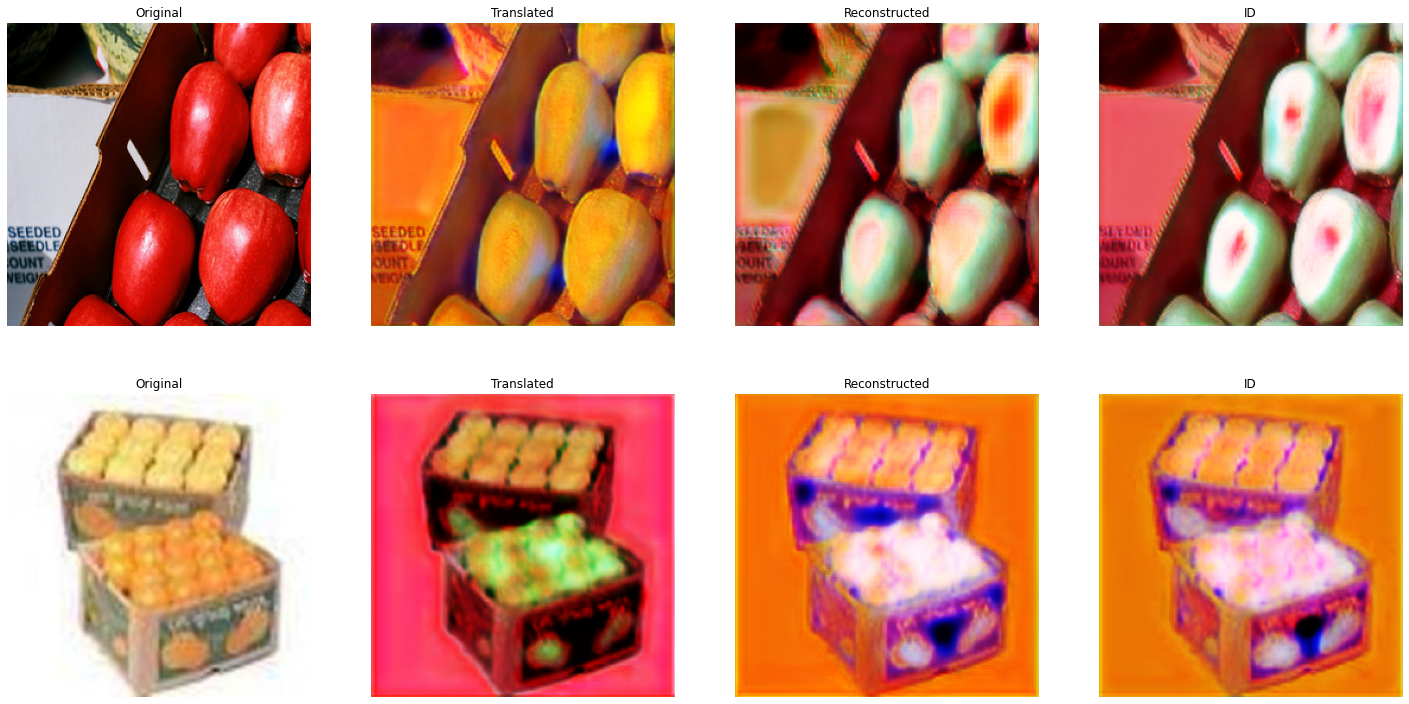

In [ ]:
def sample_images(data_loader):
    
    r, c = 2, 4
    for iter,(imgs_A,imgs_B) in enumerate(dataloader.load_batch(batch_size=1)):

        fake_B = u_B(imgs_A).detach()
        fake_A = u_A(imgs_B).detach()

        recons_A = u_A(fake_B)
        recons_B = u_B(fake_A)
        
        idt_A = u_A(imgs_A)
        idt_B = u_B(imgs_B)
        gen_imgs = torch.concatenate([imgs_A, fake_B, recons_A, idt_A, imgs_B, fake_A, recons_B, idt_B]).detach().cpu().numpy().transpose((0,2,3,1))

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        gen_imgs = np.clip(gen_imgs, 0, 1)

        titles = ['Original', 'Translated', 'Reconstructed', 'ID']
        fig, axs = plt.subplots(r, c, figsize=(25,12.5))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        
        break


sample_images(dataloader)


In [ ]:
torch.save(d_A.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/cycle_dA_unet_epoch50.pth")
torch.save(d_B.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/cycle_dB_unet_epoch50.pth")
torch.save(u_A.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/cycle_gA_unet_epoch50.pth")
torch.save(u_B.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/cycle_gB_unet_epoch50.pth")

In [ ]:

num_epochs=100
for epoch in range(50,num_epochs):
    for iter,(imgs_A,imgs_B) in enumerate(dataloader.load_batch(batch_size=batch_size)):

        fake_B = u_B(imgs_A).detach()
        fake_A = u_A(imgs_B).detach()

        d_B_loss = d_B.train(imgs_B,real_label)
        d_B_fake_loss = d_B.train(fake_B,fake_label)
        d_A_loss =d_A.train(imgs_A,real_label)
        d_A_fake_loss = d_A.train(fake_A,fake_label)

        recons_A = u_A(fake_B)
        recons_B = u_B(fake_A)
        g_A_rec_loss = u_A.train(recons_A,imgs_A)
        g_B_rec_loss = u_B.train(recons_B,imgs_B)
        
        idt_A = u_A(imgs_A)
        idt_B = u_B(imgs_B)
        
        g_A_idt_loss = u_A.train(idt_A,imgs_A)
        g_B_idt_loss = u_B.train(idt_B,imgs_B)

        total_d_A_loss =(d_A_loss.item()+d_A_fake_loss.item())/2
        total_d_B_loss =(d_B_loss.item()+d_B_fake_loss.item())/2
        dA_loss_hist.append(total_d_A_loss)
        dB_loss_hist.append(total_d_B_loss)

        total_g_A_loss =(g_A_rec_loss.item()+g_A_idt_loss.item())/2
        total_g_B_loss =(g_B_rec_loss.item()+g_B_idt_loss.item())/2
        gA_loss_hist.append(total_g_A_loss)
        gB_loss_hist.append(total_g_B_loss)

        
    print(f"Epoch {epoch}: d_A_loss = {total_d_A_loss:.7f} | d_B_loss = {total_d_B_loss:.7f} | total_g_A_loss={total_g_A_loss:.7f} | total_g_B_loss={total_g_B_loss:.7f}")



Epoch 50: d_A_loss = 0.0007569 | d_B_loss = 0.0004813 | total_g_A_loss=0.1733707 | total_g_B_loss=0.3505950
Epoch 51: d_A_loss = 0.0008143 | d_B_loss = 0.0003984 | total_g_A_loss=0.1610533 | total_g_B_loss=0.3294384
Epoch 52: d_A_loss = 0.0010507 | d_B_loss = 0.0003124 | total_g_A_loss=0.1606939 | total_g_B_loss=0.3565053
Epoch 53: d_A_loss = 0.0017670 | d_B_loss = 0.0003923 | total_g_A_loss=0.1850847 | total_g_B_loss=0.3300129
Epoch 54: d_A_loss = 0.0007915 | d_B_loss = 0.0003769 | total_g_A_loss=0.1493227 | total_g_B_loss=0.3615591
Epoch 55: d_A_loss = 0.0007121 | d_B_loss = 0.0003099 | total_g_A_loss=0.1679823 | total_g_B_loss=0.3378701
Epoch 56: d_A_loss = 0.0005393 | d_B_loss = 0.0013515 | total_g_A_loss=0.1822513 | total_g_B_loss=0.3225900
Epoch 57: d_A_loss = 0.0496796 | d_B_loss = 0.0002933 | total_g_A_loss=0.1471705 | total_g_B_loss=0.3561913
Epoch 58: d_A_loss = 0.0049701 | d_B_loss = 0.0039686 | total_g_A_loss=0.1919395 | total_g_B_loss=0.3722676
Epoch 59: d_A_loss = 0.00142

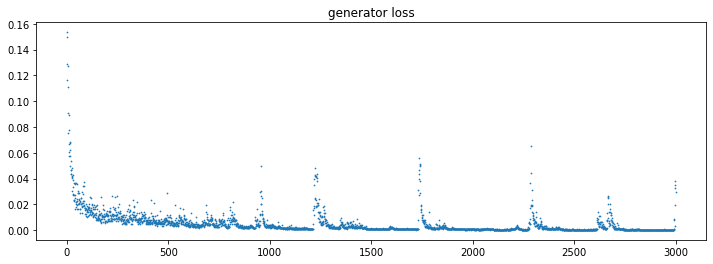

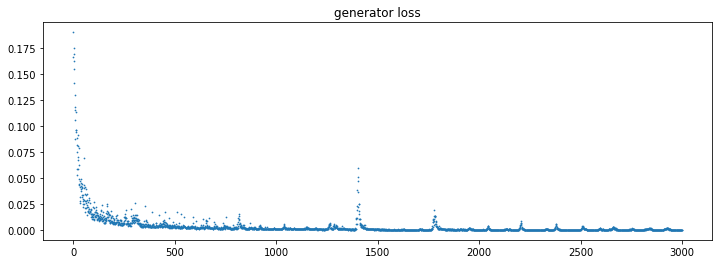

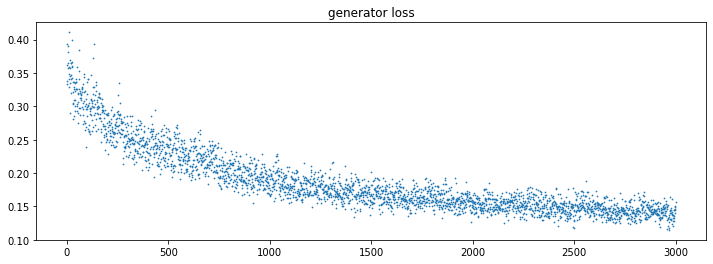

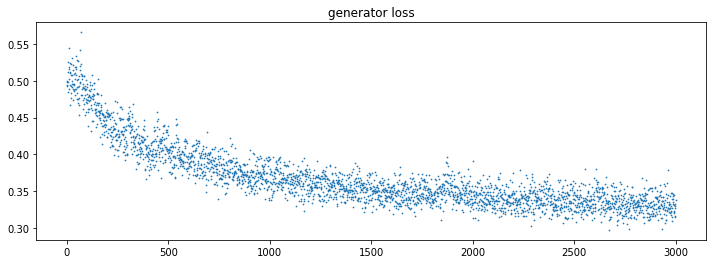

In [ ]:
visualize(dA_loss_hist)
visualize(dB_loss_hist)
visualize(gA_loss_hist)
visualize(gB_loss_hist)

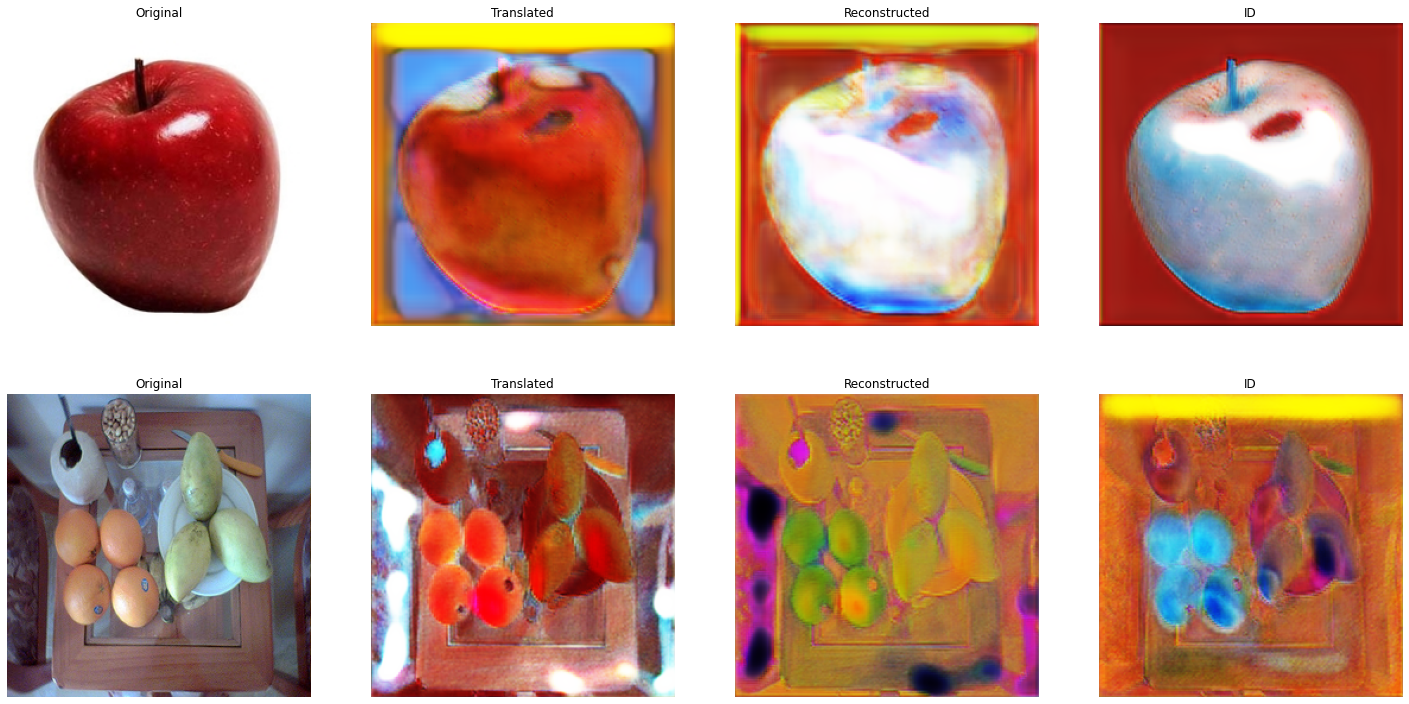

In [ ]:
sample_images(dataloader)

In [9]:
# 추가 학습
def sample_images(data_loader):
    
    r, c = 2, 4
    for iter,(imgs_A,imgs_B) in enumerate(dataloader.load_batch(batch_size=1)):

        fake_B = u_B(imgs_A).detach()
        fake_A = u_A(imgs_B).detach()

        recons_A = u_A(fake_B)
        recons_B = u_B(fake_A)
        
        idt_A = u_A(imgs_A)
        idt_B = u_B(imgs_B)
        gen_imgs = torch.concatenate([imgs_A, fake_B, recons_A, idt_A, imgs_B, fake_A, recons_B, idt_B]).detach().cpu().numpy().transpose((0,2,3,1))

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        gen_imgs = np.clip(gen_imgs, 0, 1)

        titles = ['Original', 'Translated', 'Reconstructed', 'ID']
        fig, axs = plt.subplots(r, c, figsize=(25,12.5))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        
        break
def visualize(loss_hist):
    plt.figure(figsize=(12,4))
    plt.scatter(np.arange(1,len(loss_hist)+1),loss_hist,s=0.5)
    plt.title('generator loss')
    plt.show()

In [20]:
d_A = D()
d_B = D()
u_A = UNET()
u_B = UNET()
d_A.load_state_dict(torch.load("./mount/My Drive/Colab Notebooks/GDLgon/cycle_dA_unet_epoch50.pth"))
d_B.load_state_dict(torch.load("./mount/My Drive/Colab Notebooks/GDLgon/cycle_dB_unet_epoch50.pth"))
u_A.load_state_dict(torch.load("./mount/My Drive/Colab Notebooks/GDLgon/cycle_gA_unet_epoch50.pth"))
u_B.load_state_dict(torch.load("./mount/My Drive/Colab Notebooks/GDLgon/cycle_gB_unet_epoch50.pth"))
d_A.to(device)
d_B.to(device)
u_A.to(device)
u_B.to(device)
dummy = torch.ones([2,3,256,256])

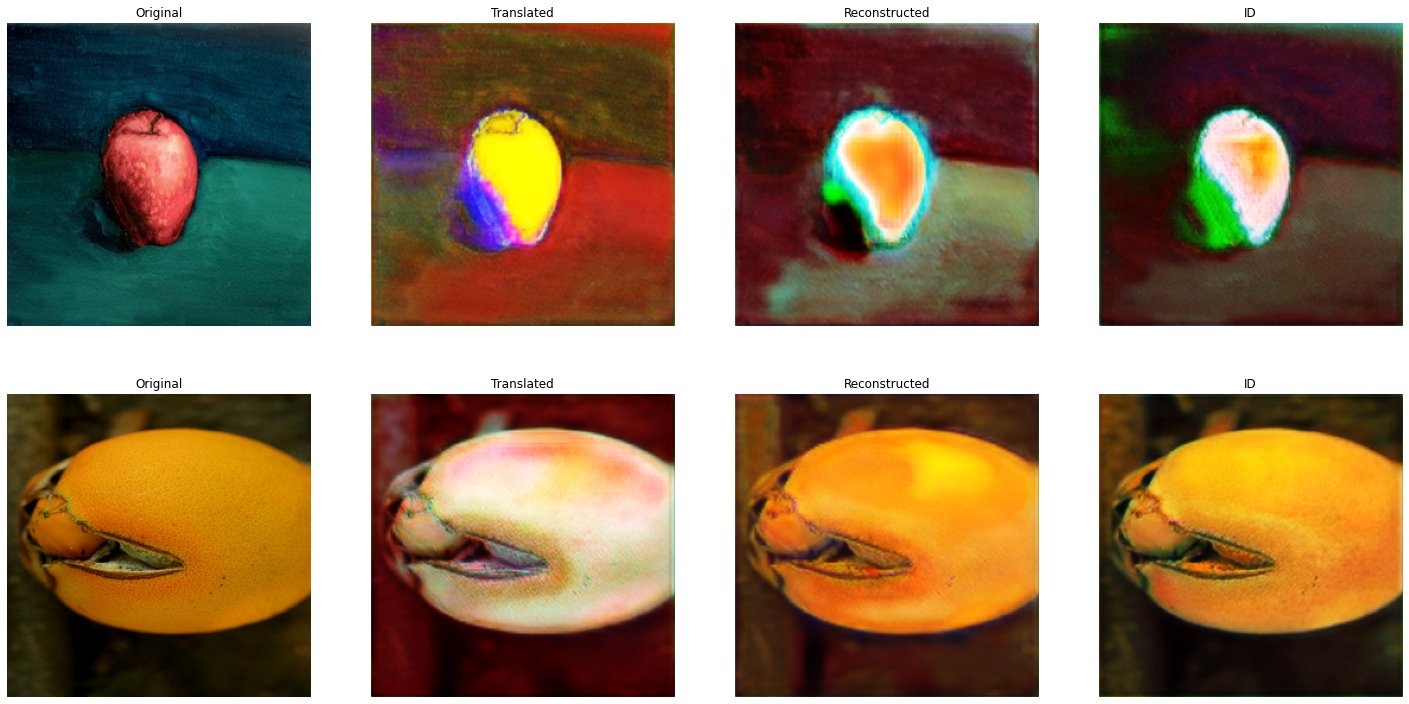

In [21]:
dataloader = apple2orangeDataLoader()
sample_images(dataloader)

In [22]:
%%time
import matplotlib.pyplot as plt



batch_size = 32
patch = int(256/2**4)
disc_patch = (1,patch,patch) #[1,16,16]

real_label = torch.ones((batch_size,)+disc_patch)
fake_label = torch.zeros((batch_size,)+disc_patch)


dA_loss_hist = []
dB_loss_hist = []
gA_loss_hist =[]
gB_loss_hist =[]


num_epochs=150
for epoch in range(50,num_epochs):
    for iter,(imgs_A,imgs_B) in enumerate(dataloader.load_batch(batch_size=batch_size)):

        fake_B = u_B(imgs_A).detach()
        fake_A = u_A(imgs_B).detach()

        d_B_loss = d_B.train(imgs_B,real_label)
        d_B_fake_loss = d_B.train(fake_B,fake_label)
        d_A_loss =d_A.train(imgs_A,real_label)
        d_A_fake_loss = d_A.train(fake_A,fake_label)

        recons_A = u_A(fake_B)
        recons_B = u_B(fake_A)
        g_A_rec_loss = u_A.train(recons_A,imgs_A)
        g_B_rec_loss = u_B.train(recons_B,imgs_B)
        
        idt_A = u_A(imgs_A)
        idt_B = u_B(imgs_B)
        
        g_A_idt_loss = u_A.train(idt_A,imgs_A)
        g_B_idt_loss = u_B.train(idt_B,imgs_B)

        total_d_A_loss =(d_A_loss.item()+d_A_fake_loss.item())/2
        total_d_B_loss =(d_B_loss.item()+d_B_fake_loss.item())/2
        dA_loss_hist.append(total_d_A_loss)
        dB_loss_hist.append(total_d_B_loss)

        total_g_A_loss =(g_A_rec_loss.item()+g_A_idt_loss.item())/2
        total_g_B_loss =(g_B_rec_loss.item()+g_B_idt_loss.item())/2
        gA_loss_hist.append(total_g_A_loss)
        gB_loss_hist.append(total_g_B_loss)

        
    print(f"Epoch {epoch}: d_A_loss = {total_d_A_loss:.7f} | d_B_loss = {total_d_B_loss:.7f} | total_g_A_loss={total_g_A_loss:.7f} | total_g_B_loss={total_g_B_loss:.7f}")



Epoch 50: d_A_loss = 0.0020679 | d_B_loss = 0.0022004 | total_g_A_loss=0.1338744 | total_g_B_loss=0.1424811
Epoch 51: d_A_loss = 0.0015579 | d_B_loss = 0.0011451 | total_g_A_loss=0.1394052 | total_g_B_loss=0.1226624
Epoch 52: d_A_loss = 0.0013403 | d_B_loss = 0.0008862 | total_g_A_loss=0.1342527 | total_g_B_loss=0.1496780
Epoch 53: d_A_loss = 0.0008123 | d_B_loss = 0.0016798 | total_g_A_loss=0.1547830 | total_g_B_loss=0.1506453
Epoch 54: d_A_loss = 0.0010248 | d_B_loss = 0.0009157 | total_g_A_loss=0.1521526 | total_g_B_loss=0.1493997
Epoch 55: d_A_loss = 0.0013520 | d_B_loss = 0.0018277 | total_g_A_loss=0.1299855 | total_g_B_loss=0.1361465
Epoch 56: d_A_loss = 0.0012310 | d_B_loss = 0.0012552 | total_g_A_loss=0.1466893 | total_g_B_loss=0.1360711
Epoch 57: d_A_loss = 0.0007270 | d_B_loss = 0.0014836 | total_g_A_loss=0.1419028 | total_g_B_loss=0.1306895
Epoch 58: d_A_loss = 0.0005594 | d_B_loss = 0.0013832 | total_g_A_loss=0.1484104 | total_g_B_loss=0.1373250
Epoch 59: d_A_loss = 0.00131

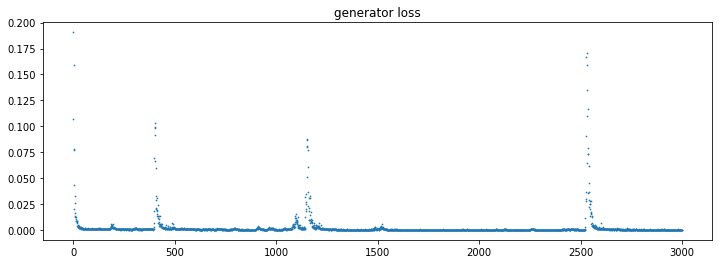

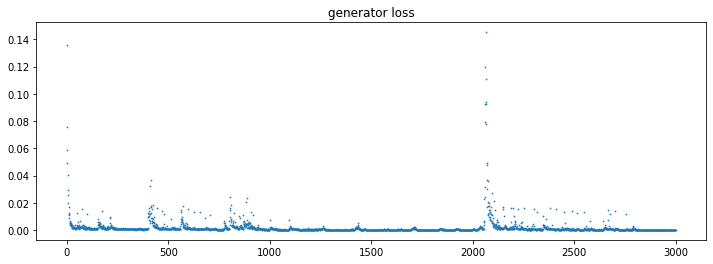

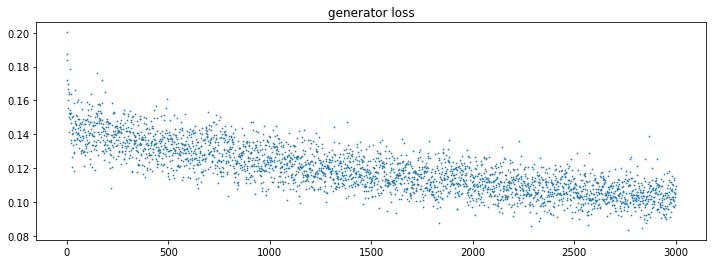

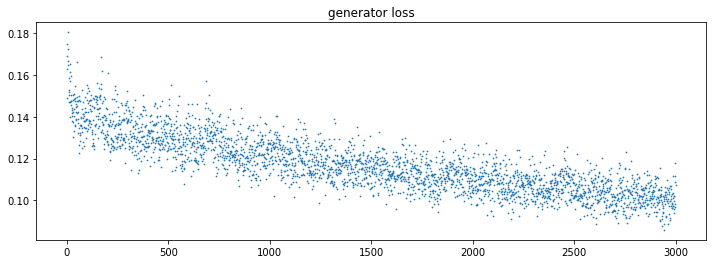

In [23]:
visualize(dA_loss_hist)
visualize(dB_loss_hist)
visualize(gA_loss_hist)
visualize(gB_loss_hist)

In [24]:
torch.save(d_A.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/cycle_dA_unet_epoch150.pth")
torch.save(d_B.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/cycle_dB_unet_epoch150.pth")
torch.save(u_A.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/cycle_gA_unet_epoch150.pth")
torch.save(u_B.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/cycle_gB_unet_epoch150.pth")

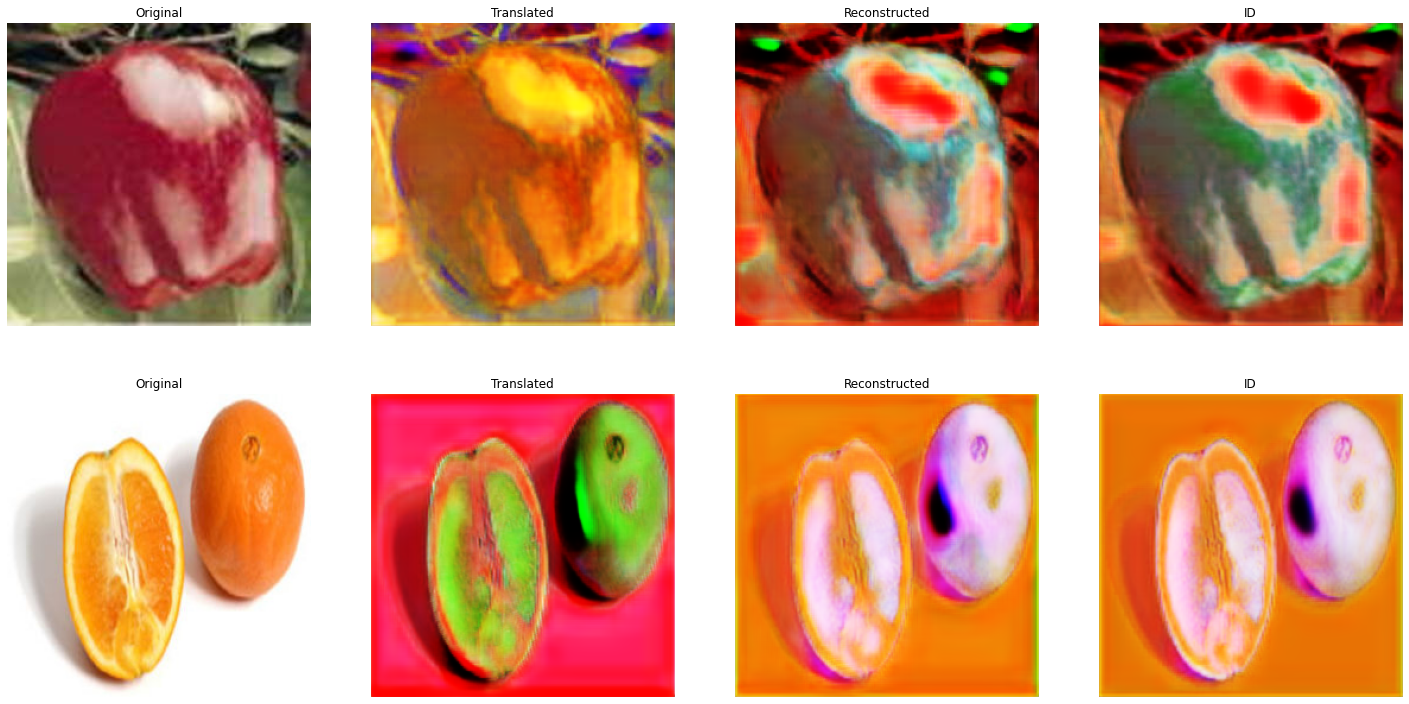

In [25]:
sample_images(dataloader)